# HBV model

This notebook can be used to run your HBV model. It imports the packages needed to run the HBV model on eWaterCycle. 

**Important:**
If you edited the code in hbv_bmi, it is important to restart the kernel and re-run the cells. 


In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# eWaterCycle packages
import ewatercycle
from forcing import HBVForcing
from ewatercycle.base.forcing import GenericLumpedForcing

In [4]:
from ewatercycle_wrapper import HBV

Important  to set paths well:

In [6]:
shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"
path = Path.cwd()
forcing_path = path / "Forcing"

specify dates

In [7]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"


setup forcing

In [8]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'Forcing.txt',
                          test_data_bool = True
                          )

In [9]:
model = HBV(forcing=test_forcing)

parameter information

In [10]:
s_0 = np.array([0,  100,  0,  5])
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
par_0 = (p_min_initial + p_max_initial)/2

In [11]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [12]:
model.initialize(config_file)

In [13]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [14]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [15]:
Q_ref = np.loadtxt('Forcing/Q_m_out_ref.txt')

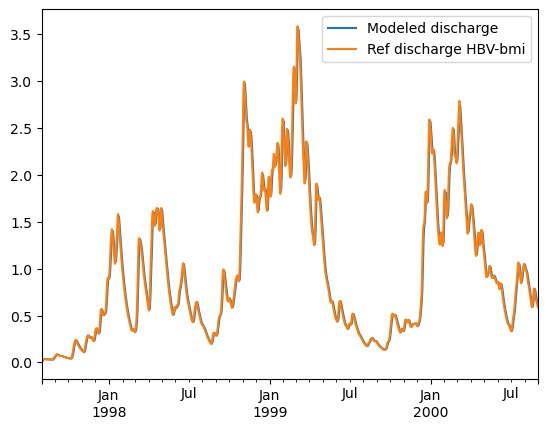

In [16]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
plt.plot(time, Q_ref[1:],label="Ref discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));

In [17]:
model.finalize()

### Check whether your code is correct
To test your HBV model, run the next cell. This is in example with different parameters and initial storages, to see if your implemented function works properly.

In this example, the Interception storage is filled with 100 mm of water and the unsaturated rootzone storage is initally 30 mm. The other storages are empty at the initial state. By using the parameter set given below, the water will divide over the other storages. 

In [169]:
forcing_test = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'Forcing_test.txt',
                          test_data_bool = True
                          )

model_test = HBV(forcing=forcing_test)
parameters_test = np.array([5,   1,  60,    1,   0.1,   5,     0.1,  0.1])
initial_storage_test = np.array([100,  30,  0,  0])
config_file_test, _ = model_test.setup(
                            parameters=','.join([str(p) for p in parameters_test]),
                            initial_storage=','.join([str(s) for s in initial_storage_test]),
                               )
model_test.initialize(config_file_test)

model_test.update()

print(model_test.get_value('Qus_dt'), model_test.get_value('Qf_dt'), model_test.get_value('Qs_dt'))
print(model_test.get_value('Si'), model_test.get_value('Sf'), model_test.get_value('Su'), model_test.get_value('Ss'))


assert np.isclose(model_test.get_value('Pe_dt'), 110, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ei_dt'), 0, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ea_dt'), 8.5, rtol=1e-4, atol=1e-4)

assert np.isclose(model_test.get_value('Si'), 5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Sf'), 49.5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Su'), 76.3725, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ss'), 0.11475, rtol=1e-4, atol=1e-4)

assert np.isclose(model_test.get_value("Qus_dt"),0.1275, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Qf_dt'), 5.5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Qs_dt'), 0.01275, rtol=1e-4, atol=1e-4)

model_test.finalize()

[0.1275] [5.5] [0.01275]
[5.] [49.5] [76.3725] [0.11475]
